In [1]:
!pip install geopandas
!pip install plotly
!pip install requests

In [2]:
import requests
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import os
import plotly.express as px
import statsmodels.api as sm

In [3]:
api_key= 'Q0dGwScJ.EdgL1P5wLue7rrlFaIjQsr27LwbZyjzu'
url= 'https://api.patentsview.org/patents/query'
params= {
    'q': '{"_gte": {"patent_date":"2023-03-31"}}', #end date is march 31, 2024
    'f': '["patent_number", "patent_title", "assignee_city", "assignee_state", "assignee_country"]',
    'o': '{"per_page":"10000"}',
    'api_key': api_key
}

response = requests.get(url, params=params)
patent_data = response.json()


In [4]:
if 'patents' in patent_data:
    for patent in patent_data['patents']:
        assignees = patent.get('assignees', [])
        if assignees:
            assignee = assignees[0]
            latitude = assignee.get('assignee_latitude')
            longitude = assignee.get('assignee_longitude')
            print(f"Patent Number: {patent['patent_number']}, Title: {patent['patent_title']}, Latitude: {latitude}, Longitude: {longitude}")
else:
    print("No patents found in the response.")


Patent Number: 11617292, Title: Method for controlling the operation of an attachment, Latitude: None, Longitude: None
Patent Number: 11617293, Title: Hitch assembly for a work vehicle, Latitude: None, Longitude: None
Patent Number: 11617294, Title: Orientation control system for an agricultural implement, Latitude: None, Longitude: None
Patent Number: 11617295, Title: Dynamic supplemental downforce control system for planter row units, Latitude: None, Longitude: None
Patent Number: 11617296, Title: Agricultural machine equipped with a distribution tie-rod, Latitude: None, Longitude: None
Patent Number: 11617297, Title: Agricultural vehicle-trailer combination, Latitude: None, Longitude: None
Patent Number: 11617298, Title: Agricultural product delivery applicator with a pneumatic conveying system having a distributor assembly, Latitude: None, Longitude: None
Patent Number: 11617299, Title: System and method for regulating and dispensing seeds, fertilizer, and other items, Latitude: No

In [5]:
print(patent_data['patents'][0])

{'patent_number': '11617292', 'patent_title': 'Method for controlling the operation of an attachment', 'assignees': [{'assignee_city': 'Moline', 'assignee_state': 'IL', 'assignee_country': 'US', 'assignee_key_id': 110}]}


In [6]:
us_patents= []
i= 0
if 'patents' in patent_data:
    for patent in patent_data['patents']:
        assignees = patent.get('assignees', [])
        if assignees:
            assignee = assignees[0]
            city = assignee.get('assignee_city')
            state = assignee.get('assignee_state')
            country= assignee.get('assignee_country')
            i= i + 1
            #print(f"Patent Number {i}: {patent['patent_number']}, Title: {patent['patent_title']}, City: {city}, State: {state}, Country: {country}")

            if country== 'US':
                us_patents.append(patent)
                
else:
    print("No patents found in the response.")

print(len(us_patents))

4797


In [7]:
us_patents[0]

{'patent_number': '11617292',
 'patent_title': 'Method for controlling the operation of an attachment',
 'assignees': [{'assignee_city': 'Moline',
   'assignee_state': 'IL',
   'assignee_country': 'US',
   'assignee_key_id': 110}]}

In [8]:
df = pd.json_normalize(us_patents, 
                       record_path='assignees', 
                       meta=['patent_number', 'patent_title'], 
                       errors='ignore')

In [9]:
df

assignee_city assignee_state assignee_country  assignee_key_id  \
0             Moline             IL               US              110   
1             Moline             IL               US              110   
2        New Holland             PA               US              278   
3            Tremont             IL               US            11209   
4             Moline             IL               US              110   
...              ...            ...              ...              ...   
4879        San Jose             CA               US            17827   
4880      Washington             DC               US           329040   
4881  West Hollywood             CA               US             3462   
4882         Suwanee             GA               US             5150   
4883        New York             NY               US              873   

     patent_number                                       patent_title  
0         11617292  Method for controlling the operation of an att...  
1         11617293                  Hitch assembly for a work vehicle  
2         11617294  Orientation control system for an agricultural...  
3         11617295  Dynamic supplemental downforce control system ...  
4         11617297           Agricultural vehicle-trailer combination  
...            ...                                                ...  
4879      11627372  Media channel identification with multi-match ...  
4880      11627373  Systems and methods for providing survey data ...  
4881      11627375  Methods and systems for generating and providi...  
4882      11627377   Set-top box ambiance and notification controller  
4883      11627378  Media presentation device with voice command f...  

[4884 rows x 6 columns]

In [10]:
# Group by city and state, count occurrences
df_counts = df.groupby(["assignee_city", "assignee_state"]).size().reset_index(name="Counts")

In [11]:
# Rename columns
df_counts.columns = ["City", "State", "Counts"]

In [12]:
df_counts_sorted= df_counts.sort_values(by="Counts", ascending=False)
df_counts_sorted.reset_index(drop= True, inplace= True)
df_counts_sorted

City State  Counts
0         San Jose    CA     159
1           Armonk    NY     156
2    San Francisco    CA     154
3      Santa Clara    CA     152
4        San Diego    CA     140
..             ...   ...     ...
914     Charleston    SC       1
915        Chatham    NJ       1
916     Miamisburg    OH       1
917    Cheektowaga    NY       1
918       Aberdeen    NC       1

[919 rows x 3 columns]

In [13]:
coord_1 = {
    'San Jose, CA': {'coordinates': (37.3361663, -121.890591), 'population': 1_028_000},
    'Armonk, NY': {'coordinates': (41.1264847, -73.7139777), 'population': 4_330},
    'San Francisco, CA': {'coordinates': (37.7792588, -122.4193286), 'population': 873_965},
    'Santa Clara, CA': {'coordinates': (37.2333253, -121.6846349), 'population': 130_000},
    'San Diego, CA': {'coordinates': (32.7174202, -117.162772), 'population': 1_386_932},
    'Mountain View, CA': {'coordinates': (37.3893889, -122.0832101), 'population': 82_739},
    'New York, NY': {'coordinates': (40.7127281, -74.0060152), 'population': 8_467_513},
    'Seattle, WA': {'coordinates': (47.6038321, -122.330062), 'population': 737_015},
    'Chicago, IL': {'coordinates': (41.8755616, -87.6244212), 'population': 2_746_388},
    'Houston, TX': {'coordinates': (29.7589382, -95.3676974), 'population': 2_304_580},
    'Dearborn, MI': {'coordinates': (42.3222599, -83.1763145), 'population': 109_976},
    'Cupertino, CA': {'coordinates': (37.3228934, -122.0322895), 'population': 60_497},
    'Redmond, WA': {'coordinates': (47.6694141, -122.1238767), 'population': 73_256},
    'Boise, ID': {'coordinates': (43.6166163, -116.200886), 'population': 235_684},
    'Charlotte, NC': {'coordinates': (35.2272086, -80.8430827), 'population': 897_720},
    'Atlanta, GA': {'coordinates': (33.7489924, -84.3902644), 'population': 498_715},
    'Cambridge, MA': {'coordinates': (42.3656347, -71.1040018), 'population': 117_090},
    'Austin, TX': {'coordinates': (30.2711286, -97.7436995), 'population': 964_177},
    'Menlo Park, CA': {'coordinates': (37.4519671, -122.177992), 'population': 34_698},
    'Palo Alto, CA': {'coordinates': (37.4443293, -122.1598465), 'population': 68_572},
    'Boston, MA': {'coordinates': (42.3554334, -71.060511), 'population': 675_647},
    'McLean, VA': {'coordinates': (38.9342888, -77.1776327), 'population': 48_066},
    'Wilmington, DE': {'coordinates': (39.7459468, -75.546589), 'population': 70_750},
    'Santa Monica, CA': {'coordinates': (34.0194704, -118.491227), 'population': 93_076},
    'Dallas, TX': {'coordinates': (32.7762719, -96.7968559), 'population': 1_339_287},
    'Washington, DC': {'coordinates': (38.8950368, -77.0365427), 'population': 689_545},
    'Sunnyvale, CA': {'coordinates': (37.3688301, -122.036349), 'population': 155_805},
    'Philadelphia, PA': {'coordinates': (39.9527237, -75.1635262), 'population': 1_603_797},
    'Spring, TX': {'coordinates': (30.0795707, -95.4187924), 'population': 62_559},
    'Minneapolis, MN': {'coordinates': (44.9772995, -93.2654692), 'population': 429_606},
    'Las Vegas, NV': {'coordinates': (36.1672559, -115.148516), 'population': 644_594},
    'Hopkinton, MA': {'coordinates': (42.2288875, -71.5196439), 'population': 18_585},
    'Detroit, MI': {'coordinates': (42.3315509, -83.0466403), 'population': 632_464},
    'Plano, TX': {'coordinates': (33.0136764, -96.6925096), 'population': 285_494},
    'Irvine, CA': {'coordinates': (33.6856969, -117.825981), 'population': 307_670},
    'Bellevue, WA': {'coordinates': (47.6144219, -122.192337), 'population': 151_854},
    'Denver, CO': {'coordinates': (39.7392364, -104.984862), 'population': 711_463},
    'Mansfield, MA': {'coordinates': (42.0334326, -71.2189405), 'population': 24_165},
    'Oakland, CA': {'coordinates': (37.8044557, -122.271356), 'population': 440_646},
    'Chesterfield, MO': {'coordinates': (38.661953, -90.5643258), 'population': 49_159},
    'Farmington, CT': {'coordinates': (41.7198216, -72.8320435), 'population': 25_800},
    'Arlington, VA': {'coordinates': (38.8769326, -77.0893094), 'population': 238_643},
    'Cincinnati, OH': {'coordinates': (39.1014537, -84.5124602), 'population': 308_929},
    'Pittsburgh, PA': {'coordinates': (40.4416941, -79.9900861), 'population': 302_971},
    'Schenectady, NY': {'coordinates': (42.8142432, -73.9395687), 'population': 66_140},
    'Beaverton, OR': {'coordinates': (45.4871723, -122.80378), 'population': 99_037},
    'Scottsdale, AZ': {'coordinates': (33.4942189, -111.926018), 'population': 258_069},
    'Redwood City, CA': {'coordinates': (37.4863239, -122.232523), 'population': 86_380},
    'Redwood Shores, CA': {'coordinates': (37.5318804, -122.2480219), 'population': 10_850},
    'San Mateo, CA': {'coordinates': (37.496904, -122.3330573), 'population': 105_661},
    'Auburn Hills, MI': {'coordinates': (42.6875323, -83.2341028), 'population': 24_974},
    'Waltham, MA': {'coordinates': (42.3756401, -71.2358004), 'population': 62_782},
    'Torrance, CA': {'coordinates': (33.8371392, -118.3413606), 'population': 147_067},
    'Indianapolis, IN': {'coordinates': (39.7683331, -86.1583502), 'population': 887_232},
    'Milwaukee, WI': {'coordinates': (43.0386475, -87.9090751), 'population': 594_548},
    'Benton Harbor, MI': {'coordinates': (42.1167065, -86.4541894), 'population': 9_635},
    'Carlsbad, CA': {'coordinates': (33.1580933, -117.3505966), 'population': 115_302},
    'Peoria, IL': {'coordinates': (40.6938609, -89.5891008), 'population': 112_934},
    'San Antonio, TX': {'coordinates': (29.4246002, -98.4951405), 'population': 1_451_853},
    'Suwanee, GA': {'coordinates': (34.0514898, -84.0712997), 'population': 21_508},
    'New Holland, PA': {'coordinates': (40.1017643, -76.085227), 'population': 5_403},
    'Durham, NC': {'coordinates': (35.996653, -78.9018053), 'population': 285_527},
    'Pleasanton, CA': {'coordinates': (37.6624312, -121.8746789), 'population': 81_777},
    'Los Angeles, CA': {'coordinates': (34.0536909, -118.242766), 'population': 3_898_747},
    'Plantation Gardens, FL': {'coordinates': (26.1298084, -80.2375483), 'population': 94_950},
    'Round Rock, TX': {'coordinates': (30.5085915, -97.6788056), 'population': 133_372},
    'Broomfield, CO': {'coordinates': (39.9403995, -105.05208), 'population': 75_407},
    'Bozeman, MT': {'coordinates': (45.6794293, -111.044047), 'population': 53_293},
    'Phoenix, AZ': {'coordinates': (33.4484367, -112.074141), 'population': 1_608_139},
    'Raleigh, NC': {'coordinates': (35.7803977, -78.6390989), 'population': 474_069},
    'Foster City, CA': {'coordinates': (37.5600336, -122.2688522), 'population': 34_209},
    'Madison, WI': {'coordinates': (43.074761, -89.3837613), 'population': 269_196},
    'Los Altos, CA': {'coordinates': (37.3790629, -122.116578), 'population': 30_729},
    'Addison, TX': {'coordinates': (32.960477850000004, -96.8300673063398), 'population': 16_280},
    'Hickory, NC': {'coordinates': (35.7333312, -81.3442915), 'population': 43_490},
    'Okabena, MN': {'coordinates': (43.739404, -95.3158321), 'population': 173},
    'Fort Lauderdale, FL': {'coordinates': (26.1223084, -80.1433786), 'population': 182_760},
    'Moline, IL': {'coordinates': (41.5058344, -90.5136642), 'population': 41_953},
    'Brookfield, WI': {'coordinates': (43.0578479, -88.1261984), 'population': 40_735},
    'Purchase, NY': {'coordinates': (41.0409305, -73.7145746), 'population': 5_393},
    'Melbourne, FL': {'coordinates': (28.0785034, -80.6077908), 'population': 85_062},
    'Boca Raton, FL': {'coordinates': (26.3586885, -80.0830984), 'population': 97_468},
    'Franklin Lakes, NJ': {'coordinates': (41.0167639, -74.2057012), 'population': 11_084},
    'Chandler, AZ': {'coordinates': (33.3062031, -111.841185), 'population': 275_987},
    'Salt Lake City, UT': {'coordinates': (40.7596198, -111.886797), 'population': 199_649},
    'Bentonville, AR': {'coordinates': (36.3728538, -94.2088172), 'population': 54_164},
    'Pasadena, CA': {'coordinates': (34.1476507, -118.144155), 'population': 138_699},
    'Sugar Land, TX': {'coordinates': (29.6196787, -95.6349463), 'population': 118_600},
    'Fremont, CA': {'coordinates': (37.5482697, -121.988571), 'population': 234_962},
    'Columbus, OH': {'coordinates': (39.9622601, -83.0007065), 'population': 922_223},
    'Reston, VA': {'coordinates': (38.953055899999995, -77.35021396591173), 'population': 63_226},
    'Corning, NY': {'coordinates': (42.1435257, -77.0543408), 'population': 10_396},
    'Milpitas, CA': {'coordinates': (37.4332273, -121.8989248), 'population': 84_196},
    'Providence, RI': {'coordinates': (41.8239891, -71.4128343), 'population': 190_934},
    'Santa Rosa, CA': {'coordinates': (38.4404925, -122.7141049), 'population': 176_938},
    'Stamford, CT': {'coordinates': (41.0534302, -73.5387341), 'population': 136_309},
    'Maple Grove, MN': {'coordinates': (45.0984983, -93.4419222), 'population': 73_839},
    'Columbus, IN': {'coordinates': (39.2014405, -85.9213796), 'population': 49_170},
}


In [14]:
coord_2 = {
    'Rochester, NY': {'coordinates': (43.157285, -77.615214), 'population': 211_328},
    'Cleveland, OH': {'coordinates': (41.4996574, -81.6936772), 'population': 368_073},
    'Kalamazoo, MI': {'coordinates': (42.291707, -85.5872286), 'population': 73_598},
    'Monet, FL': {'coordinates': (26.8381164, -80.0942089), 'population': 42_205},
    'Wauwatosa, WI': {'coordinates': (43.0494122, -88.0079271), 'population': 48_387},
    'Burlington, MA': {'coordinates': (42.5048167, -71.1956111), 'population': 27_027},
    'Winston-Salem, NC': {'coordinates': (36.0998131, -80.2440518), 'population': 250_765},
    'South Burlington, VT': {'coordinates': (44.4671635, -73.1715669), 'population': 20_292},
    'Greensboro, NC': {'coordinates': (36.0726355, -79.7919754), 'population': 299_035},
    'Alpharetta, GA': {'coordinates': (34.0709576, -84.2747329), 'population': 67_213},
    'Ann Arbor, MI': {'coordinates': (42.2813722, -83.7484616), 'population': 123_851},
    'Bedford, MA': {'coordinates': (42.4917301, -71.2817947), 'population': 14_383},
    'Newport Beach, CA': {'coordinates': (33.6170092, -117.9294401), 'population': 85_694},
    'South San Francisco, CA': {'coordinates': (37.6535403, -122.4168664), 'population': 67_789},
    'Englewood, CO': {'coordinates': (39.6482059, -104.9879641), 'population': 34_059},
    'Colorado Springs, CO': {'coordinates': (38.8339578, -104.825348), 'population': 489_529},
    'Grand Rapids, MI': {'coordinates': (42.9632425, -85.6678639), 'population': 202_767},
    'Tinley Park, IL': {'coordinates': (41.5733669, -87.7844944), 'population': 54_244},
    'Northbrook, IL': {'coordinates': (42.128704, -87.8265089), 'population': 35_222},
    'McNeil, CA': {'coordinates': (43.67934495, -79.28214780809049), 'population': 1_177},
    'Brooklyn, NY': {'coordinates': (40.6526006, -73.9497211), 'population': 2_736_074},
    'Monrovia, CA': {'coordinates': (34.1483499, -118.0014517), 'population': 37_931},
    'Rockville, MD': {'coordinates': (39.0817985, -77.1516844), 'population': 68_401},
    'Richmond, VA': {'coordinates': (37.5385087, -77.43428), 'population': 227_032},
    'Raynham, MA': {'coordinates': (41.9487118, -71.0731008), 'population': 14_548},
    'Warsaw, IN': {'coordinates': (41.2381017, -85.8530544), 'population': 15_114},
    'Framingham, MA': {'coordinates': (42.2773177, -71.4165905), 'population': 72_362},
    'Memphis, TN': {'coordinates': (35.1460249, -90.0517638), 'population': 628_127},
    'Cedar Rapids, IA': {'coordinates': (41.9758872, -91.6704053), 'population': 137_710},
    'Malvern, PA': {'coordinates': (40.036202, -75.5138959), 'population': 3_442},
    'Norwalk, CT': {'coordinates': (41.1175966, -73.4078968), 'population': 91_184},
    'Livermore, CA': {'coordinates': (37.6820583, -121.768053), 'population': 91_617},
    'Campbell, CA': {'coordinates': (37.2870626, -121.944881), 'population': 43_959},
    'Overland Park, KS': {'coordinates': (38.9742502, -94.6851702), 'population': 200_773},
    'Bloomington, IL': {'coordinates': (40.4797828, -88.9939147), 'population': 78_680},
    'Burbank, CA': {'coordinates': (34.1812089, -118.307201), 'population': 105_401},
    'Shelton, CT': {'coordinates': (41.370196, -73.150955), 'population': 41_141},
    'Huntsville, AL': {'coordinates': (34.729847, -86.5859011), 'population': 221_986},
    'Eden Prairie, MN': {'coordinates': (44.8546856, -93.470786), 'population': 65_620},
    'Southfield, MI': {'coordinates': (42.4733689, -83.2218731), 'population': 76_618},
    'West Lafayette, IN': {'coordinates': (40.4258686, -86.9080655), 'population': 49_004},
    'Glenview, IL': {'coordinates': (42.0700662, -87.8114044), 'population': 49_824},
    'Tucson, AZ': {'coordinates': (32.2228765, -110.974847), 'population': 542_629},
    'Germantown, MD': {'coordinates': (39.17130815, -77.26557848822242), 'population': 91_249},
    'Charlottesville, VA': {'coordinates': (38.029306, -78.4766781), 'population': 46_553},
    'Middleton, WI': {'coordinates': (43.0962919, -89.5119565), 'population': 22_169},
    'Tampa, FL': {'coordinates': (27.9477595, -82.458444), 'population': 399_700},
    'Chimney Lakes, FL': {'coordinates': (30.1963894, -81.8004201), 'population': 11_946},
    'Troy, MI': {'coordinates': (42.7284117, -73.6917878), 'population': 87_252},
    'Jacksonville, FL': {'coordinates': (30.3321838, -81.655651), 'population': 949_611},
    'Tulsa, OK': {'coordinates': (36.1563122, -95.9927516), 'population': 413_066},
    'Twin Lakes, CA': {'coordinates': (34.9871933, -118.5145308), 'population': 1_635},
    'Fort Collins, CO': {'coordinates': (40.5871782, -105.0770113), 'population': 170_318},
    'Mayfield Heights, OH': {'coordinates': (41.5192189, -81.457896), 'population': 18_799},
    'Louisville, CO': {'coordinates': (39.977763, -105.1319296), 'population': 21_392},
    'West Point, IA': {'coordinates': (40.7173713, -91.4530771), 'population': 972},
    'College Station, TX': {'coordinates': (30.6183939, -96.3455991), 'population': 120_019},
    'Manchester, NH': {'coordinates': (42.9956397, -71.4547891), 'population': 115_644},
    'Zeeland, MI': {'coordinates': (42.8123375, -86.0165267), 'population': 5_658},
    'Midland School, CA': {'coordinates': (34.7315638, -120.0875652), 'population': 85},
    'Midland, MI': {'coordinates': (31.83688, -102.0103767), 'population': 41_833},
    'Goleta, CA': {'coordinates': (34.4358295, -119.8276389), 'population': 32_690},
    'Richland, WA': {'coordinates': (46.2804298, -119.275205), 'population': 62_402},
    'Orlando, FL': {'coordinates': (28.5421109, -81.3790304), 'population': 307_573},
    'Brooks Road, CA': {'coordinates': (43.7913876, -79.20671357095105), 'population': 15_935},
    'Brooklyn Park, MN': {'coordinates': (45.1004807, -93.3443585), 'population': 86_478},
    'Portland, OR': {'coordinates': (45.5202471, -122.674194), 'population': 652_573},
    'Princeton, NJ': {'coordinates': (40.3496953, -74.6597376), 'population': 30_681},
    'Boulder, CO': {'coordinates': (40.0149856, -105.270545), 'population': 104_930},
    'Kirkland, WA': {'coordinates': (47.6765382, -122.2070775), 'population': 92_175},
    'Reno, NV': {'coordinates': (39.5261206, -119.8126581), 'population': 267_406},
    'Lakewood, CO': {'coordinates': (39.7085736, -105.0846694), 'population': 160_241},
    'Columbia, MD': {'coordinates': (39.1938429, -76.86460919353361), 'population': 105_412},
    'Hayward, CA': {'coordinates': (37.6688205, -122.080796), 'population': 163_265},
    'Baltimore, MD': {'coordinates': (39.2908816, -76.610759), 'population': 576_498},
    'Saratoga, CA': {'coordinates': (37.2638324, -122.0230146), 'population': 30_569},
    'Bethesda, MD': {'coordinates': (38.9846816, -77.0942447), 'population': 68_056},
    'Billerica, MA': {'coordinates': (42.5584264, -71.268947), 'population': 43_103},
    'Lisle, IL': {'coordinates': (41.801159, -88.0747687), 'population': 22_964},
    'Evanston, IL': {'coordinates': (42.0470043, -87.6846053), 'population': 78_343},
    'Hanover, MD': {'coordinates': (39.1928853, -76.7241371), 'population': 20_844},
    'Ewing, NJ': {'coordinates': (40.2688105, -74.8006895), 'population': 36_556},
    'Fairhaven, MA': {'coordinates': (41.6376043, -70.9036487), 'population': 15_924},
    'Hanover, NH': {'coordinates': (43.7023545, -72.2892164), 'population': 11_513},
    'Gaithersburg, MD': {'coordinates': (39.1399187, -77.1929215), 'population': 69_657},
    'Holland, MI': {'coordinates': (42.7876022, -86.1090828), 'population': 35_973},
    'Florham Park, NJ': {'coordinates': (40.7881643, -74.3891647), 'population': 11_946},
    'Knoxville, TN': {'coordinates': (35.9603948, -83.9210261), 'population': 190_224},
    'Irving, TX': {'coordinates': (32.8295183, -96.9442177), 'population': 256_684},
    'Franklin, TN': {'coordinates': (35.925206, -86.8689419), 'population': 88_193},
    'Fort Worth, TX': {'coordinates': (32.753177, -97.3327459), 'population': 956_709},
    'Manassas, VA': {'coordinates': (38.7509488, -77.4752667), 'population': 42_772},
    'Malibu, CA': {'coordinates': (34.035591, -118.689423), 'population': 10_654},
    'Oak Ridge, TN': {'coordinates': (36.0103562, -84.2696449), 'population': 31_402},
    'Palatine, IL': {'coordinates': (42.1105779, -88.0336888), 'population': 67_482},
    'Parsippany, NJ': {'coordinates': (40.8578772, -74.4259866), 'population': 54_460},
    'Peabody, MA': {'coordinates': (42.5278731, -70.9286609), 'population': 54_680},
    'Bothell, WA': {'coordinates': (47.7623204, -122.2054035), 'population': 48_161},
    'Provo, UT': {'coordinates': (40.2337289, -111.6587085), 'population': 116_618},
    'Rockaway, NJ': {'coordinates': (40.9012101, -74.5143232), 'population': 6_430}
}

In [15]:
# This dictionary doesn't have populations, but since they don't get plotted, it's okay to ignore

coord_3= {'Saginaw, MI': (43.3326882, -84.0468403),
 'Berkeley, CA': (37.8708393, -122.272863),
 'San Ramon, CA': (37.7648021, -121.9544387),
 'Baton Rouge, LA': (30.4494155, -91.1869659),
 'Sidney, OH': (40.284241, -84.1555267),
 'South Jordan, UT': (40.5584882, -111.9367107),
 'Vienna, VA': (38.9013729, -77.2651762),
 'Virginia Beach, VA': (36.8496579, -75.9760751),
 'Albuquerque, NM': (35.0841034, -106.650985),
 'Wilmington, MA': (42.5464828, -71.1736669),
 'Alameda, CA': (37.6090291, -121.899142),
 'Burnsville, MN': (44.7670567, -93.2773887),
 'Emeryville, CA': (37.8314089, -122.2865266),
 'Needham, MA': (42.2802645, -71.2360624),
 'Nonatum Mills, DE': (39.6946641, -75.7393074),
 'Miami, FL': (25.7741728, -80.19362),
 'Medina, MN': (45.0151361, -93.574375),
 'Maumee, OH': (41.5628294, -83.6538244),
 'New Haven, CT': (41.3082138, -72.9250518),
 'Northfield, IL': (42.09975, -87.7808967),
 'The Woodlands, TX': (30.1734194, -95.504686),
 'Thousand Oaks, CA': (34.1705609, -118.8375937),
 'Tysons, VA': (38.9191272, -77.22296360086021),
 'Urbana, IL': (40.1117174, -88.207301),
 'Mettawa, IL': (42.2333571, -87.9259058),
 'Watertown, MA': (42.3652518, -71.1843236),
 'Watertown, SD': (44.899211, -97.115289),
 'State College, PA': (40.7944504, -77.8616386),
 'Flagstaff, AZ': (35.1987522, -111.651822),
 'Louisville, KY': (38.2542376, -85.759407),
 'Fargo, ND': (46.877229, -96.789821),
 'Marshall, TX': (32.5447756, -94.3661004),
 'Worcester, MA': (42.2625621, -71.8018877),
 'York, PA': (39.962493, -76.7276989),
 'Evansdale, FL': (28.7483282, -81.3192335),
 'Tempe, AZ': (33.4255117, -111.940016),
 'Gainesville, FL': (29.6519684, -82.3249846),
 'Frisco, TX': (33.1505998, -96.8238183),
 'Orem, UT': (40.2981599, -111.6944313),
 'Kansas City, MO': (39.100105, -94.5781416),
 'Newark, CA': (37.5296593, -122.0402399),
 'Perry, OK': (36.2907352, -97.288396),
 'Plymouth, MI': (42.7369124, -96.2213607),
 'Katy, TX': (29.7857853, -95.8243956),
 'New Providence, NJ': (40.6984348, -74.4015405),
 'Rochester, NH': (43.3041111, -70.9759638),
 'Marlborough, MA': (42.3459271, -71.5522874),
 'New Orleans, LA': (29.9759983, -90.0782127),
 'San Fernando, CA': (34.28497, -118.437652),
 'Minnetonka, MN': (44.9405086, -93.4638936),
 'Lawrence, MA': (42.7070354, -71.1631137),
 'Miami Beach, FL': (25.7929198, -80.1353006),
 'Sioux Falls, SD': (43.5476008, -96.7293629),
 'Spokane, WA': (47.6571934, -117.42351),
 'Rochester Hills, MI': (42.6583661, -83.1499322),
 'Beverly Hills, CA': (34.0696501, -118.3963062),
 'Alexandria, VA': (38.8051095, -77.0470229),
 'Cypress, CA': (33.8248235, -118.0399368),
 'Des Moines, IA': (41.5868654, -93.6249494),
 'Audubon, PA': (40.131174400000006, -75.42279892329418),
 'Allentown, PA': (40.6022059, -75.4712794),
 "Coeur d'Alene, ID": (47.6742994, -116.7811531),
 'Brookhaven, GA': (33.8584368, -84.340203),
 'East Syracuse, NY': (43.0653446, -76.0785332),
 'Davidson, NC': (35.7902384, -80.2115053),
 'Danbury, CT': (41.394817, -73.4540111),
 'Culver City, CA': (34.0211224, -118.396466),
 'Coopersburg, PA': (40.51146, -75.3903376),
 'Duluth, GA': (34.0028569, -84.1441046),
 'Kohler, WI': (43.7391616, -87.7817541),
 'Rockford, IL': (42.2713945, -89.093966),
 'Klamath Falls, OR': (42.224867, -121.78167),
 'New Richmond, IN': (40.193474, -86.97975343136028),
 'Lewisville, TX': (33.046233, -96.994174),
 'Lewes, DE': (38.7733961, -75.1379574),
 'Lehi, UT': (40.3881114, -111.8486019),
 'New Albany, IN': (38.2856247, -85.8241312),
 'Leesburg, VA': (39.1154506, -77.5645607),
 'Tallahassee, FL': (30.4380832, -84.2809332),
 'Lakeland, NY': (43.0903976, -76.2403355),
 'Lebanon, NH': (43.643032, -72.251587),
 'Carpinteria, CA': (34.3988838, -119.5184564),
 'Neenah, WI': (44.1858193, -88.462609),
 'Tarrytown, NY': (41.0762077, -73.8587461),
 'Lake Zurich, IL': (42.1969689, -88.0934108),
 'Lubbock, TX': (33.5855677, -101.8470215),
 'Birmingham, AL': (33.5206824, -86.8024326),
 'Toledo, OH': (41.6529143, -83.5378173),
 'Hudson, MA': (42.3913503, -71.5676895),
 'Bloomfield, CT': (41.826488, -72.7300945),
 'Richardson, TX': (32.9481789, -96.7297206),
 'Huntersville, NC': (35.4108278, -80.8429304),
 'Deerfield, IL': (42.1711365, -87.8445119),
 'Hyannis, MA': (41.6534847, -70.2823732),
 'Idlewild, MI': (39.1090624, -120.160119),
 'North Bloomfield, OH': (41.4628274, -80.8683281),
 'Annapolis, MD': (38.9786401, -76.492786),
 'Dayton, OH': (39.7589478, -84.1916069),
 'Blacksburg, VA': (37.2296566, -80.4136767),
 'Ithaca, NY': (42.437417499999995, -76.54837235139263),
 'Jersey City, NJ': (40.7215682, -74.047455),
 'Newtown Square, PA': (39.9868117, -75.4007633),
 'Rochester, MN': (44.0234387, -92.4630182),
 'Dale, IN': (38.1689416, -86.9899966),
 'Apex, NC': (35.7325352, -78.8505516),
 'Natick, MA': (42.2836393, -71.346996),
 'Kenner, LA': (29.9942265, -90.2417806),
 'Camp Dennison, OH': (39.1981151, -84.2888265),
 'Cookeville, TN': (36.1623886, -85.4997057),
 'Nashua, NH': (42.7656251, -71.4677032),
 'Cerritos, CA': (33.8644291, -118.0539323),
 'Auburn, AL': (32.6098566, -85.4807825),
 'Marshalltown, IA': (42.048881, -92.9122672),
 'Avon, OH': (41.4516512, -82.0350598),
 'Santa Ana, CA': (33.7494951, -117.873221),
 'Somerville, MA': (42.3875968, -71.0994968),
 'Cockeysville, MD': (39.483758800000004, -76.6235105199021),
 'Maynard, MA': (42.4321064, -71.4539683),
 'Cedar Park, TX': (30.5217116, -97.827833),
 'Milwaukie, OR': (45.4440051, -122.6412523),
 'Santa Fe Springs, CA': (33.9480787, -118.0691499),
 'Sparta, WI': (43.9440667, -90.8108268),
 'Melville, NY': (40.7934322, -73.4151214),
 'Simi Valley, CA': (34.2677404, -118.7538071),
 'Clearwater, FL': (27.9658533, -82.8001026),
 'Menands, NY': (42.6920233, -73.7245639),
 'Barneveld, WI': (43.0153376, -89.8958792),
 'Shelby Charter Township, MI': (42.6696409, -83.0338011),
 'Meridian Avenue, CT': (47.0582979, -122.293795),
 'Chapel Hill, NC': (35.9131542, -79.05578),
 'Baytown, TX': (29.7355047, -94.9774274),
 'Sandy, UT': (40.5710454, -111.8953815),
 'College Hill, PA': (40.7032968, -75.2073622),
 'Lincolnshire, IL': (42.1900249, -87.9084039),
 'Stratford, CT': (41.1845415, -73.1331651),
 'North Little Rock, AR': (34.769536, -92.2670941),
 'Little Falls, NJ': (40.8689882, -74.2082011),
 'Littleton, CO': (39.613321, -105.016649),
 'Saint Paul, MN': (44.9497487, -93.0931028),
 'Livonia, MI': (42.36837, -83.3527097),
 'Morrisville, NC': (35.824341, -78.8300321),
 'Morristown, NJ': (40.7970382, -74.4809868),
 'Salina, KS': (38.8402805, -97.6114237),
 'Los Altos Hills, CA': (37.3796627, -122.137463),
 'Los Gatos, CA': (37.226611, -121.9746797),
 'Cary, NC': (35.7882893, -78.7812081),
 'Concord, MA': (42.4605189, -71.3488963),
 'San Clemente, CA': (33.4270275, -117.6124179),
 'Bend, OR': (44.0581728, -121.3153096),
 'Stanford, CA': (37.426540700000004, -122.17030545534064),
 'Columbia, SC': (34.0003117, -81.0331309),
 'Malta, NY': (42.9711708, -73.792926),
 'St. Petersburg, FL': (27.7700475, -82.6359078),
 'Springfield, VA': (38.7767435, -77.1807019310668),
 'Springfield, IL': (39.7990175, -89.6439575),
 'Bloomfield Hills, MI': (42.583645, -83.2454883),
 'Niskayuna, NY': (42.8154056, -73.8928774),
 'Chelmsford, MA': (42.5968617, -71.3517602),
 'Orland Park, IL': (41.630663, -87.8536288),
 'Fort Lupton, CO': (40.0847055, -104.813027),
 'Osprey, FL': (27.190389500000002, -82.47923200437916),
 'Oshkosh, WI': (44.0206919, -88.5408574),
 'Orrville, OH': (40.8436664, -81.7640212),
 'Glenwillow, OH': (41.361721, -81.46956),
 'Albany, NY': (42.6511674, -73.754968),
 'Aliso Viejo, CA': (33.5761376, -117.7258122),
 'Oxford, CT': (41.4351795, -73.1172769),
 'Wilmington, NC': (34.2257282, -77.9447107),
 'Patterson, OH': (40.7806102, -83.5257602),
 'Pullman, WA': (46.7304268, -117.173895),
 'Omaha, NE': (41.2587459, -95.9383758),
 'Akron, OH': (41.083064, -81.518485),
 'Woburn, MA': (42.4792618, -71.1522766),
 'Wickford, RI': (41.5739753, -71.4614464),
 'Oxford, MA': (42.1170157, -71.8644387),
 'Ogden, UT': (41.2230048, -111.9738429),
 'Westport, CT': (41.1414855, -73.3578955),
 'Westminster, MD': (39.5751717, -76.9959168),
 'Franklin Park, IL': (41.9353084, -87.865618),
 'Plymouth, MN': (45.0065149, -93.46651),
 'Westlake, OH': (41.4553232, -81.9179174),
 'Fresno, CA': (36.7394421, -119.78483),
 'Fullerton, CA': (33.8708215, -117.929416),
 'Foxborough, MA': (42.0653768, -71.2478308),
 'Wichita, KS': (37.6922361, -97.3375448),
 'Gainesville, TX': (33.6258504, -97.1332963),
 'Westborough, MA': (42.2694308, -71.6129907),
 'East Lansing, MI': (42.7320307, -84.4721678),
 'Gastonia, NC': (35.2622654, -81.1838186),
 'Potomac, MD': (39.017936, -77.2094542),
 'Buffalo Grove, IL': (42.1544205, -87.9589621),
 'Woodbury, NY': (40.8256545, -73.4676225),
 'Waterbury, CT': (41.5538091, -73.0438362),
 'Calabasas, CA': (34.1446643, -118.644097),
 'Petaluma, CA': (38.2325829, -122.636465),
 'Hartford, CT': (41.764582, -72.6908547),
 'Hartsville, SC': (34.3740431, -80.0734005),
 'Hauppauge, NY': (40.8256537, -73.2026138),
 'Yardley, PA': (40.245664, -74.8459972),
 'Village of La Jolla, CA': (32.8443342, -117.2709217),
 'American Fork, UT': (40.3768064, -111.7959146),
 'Elkhart, IN': (41.6012796, -85.8590603),
 'Fairfax, VA': (38.8156356, -77.2836849),
 'Norwood, MA': (42.194543, -71.1994976),
 'Vancouver, WA': (45.6306954, -122.6744557),
 'Elyria, OH': (41.3673191, -82.1073583),
 'Northville, MI': (42.4310816, -83.4832339),
 'Valencia, CA': (10.170026, -68.0003987),
 'Ames, IA': (42.0267567, -93.6170448),
 'Raritan, NJ': (40.567181, -74.634683),
 'Branford, CT': (41.2795414, -72.8150989),
 'Waco, TX': (31.5491899, -97.1474628),
 'Wakefield, MA': (42.506484, -71.0728306),
 'Ocala, FL': (29.1871986, -82.1400923),
 'Hamilton, OH': (39.2085354, -84.5501874),
 'Elder Mountain, TN': (35.1056293, -85.3957943),
 'Falls Church, VA': (38.882334, -77.1710914),
 'Walnut Creek, CA': (37.9020731, -122.0618702)}

In [16]:
import pandas as pd

# Example dictionary coord_2
# coord_2 = {
#     'Rochester, NY': {'coordinates': (43.157285, -77.615214), 'population': 211_328},
#     'Cleveland, OH': {'coordinates': (41.4996574, -81.6936772), 'population': 368_073},
#     'Kalamazoo, MI': {'coordinates': (42.291707, -85.5872286), 'population': 73_598}
# }

# Convert the dictionary into a format suitable for DataFrame creation
# Extract latitude and longitude from the 'coordinates' tuple
data = {
    'City': [],
    'Latitude': [],
    'Longitude': [],
    'Population': []
}

for city, info in coord_1.items():
    data['City'].append(city)
    data['Latitude'].append(info['coordinates'][0])
    data['Longitude'].append(info['coordinates'][1])
    data['Population'].append(info['population'])

for city, info in coord_2.items():
    data['City'].append(city)
    data['Latitude'].append(info['coordinates'][0])
    data['Longitude'].append(info['coordinates'][1])
    data['Population'].append(info['population'])

# Create the DataFrame
com_df = pd.DataFrame(data)

com_df


City   Latitude   Longitude  Population
0         San Jose, CA  37.336166 -121.890591     1028000
1           Armonk, NY  41.126485  -73.713978        4330
2    San Francisco, CA  37.779259 -122.419329      873965
3      Santa Clara, CA  37.233325 -121.684635      130000
4        San Diego, CA  32.717420 -117.162772     1386932
..                 ...        ...         ...         ...
193     Parsippany, NJ  40.857877  -74.425987       54460
194        Peabody, MA  42.527873  -70.928661       54680
195        Bothell, WA  47.762320 -122.205404       48161
196          Provo, UT  40.233729 -111.658709      116618
197       Rockaway, NJ  40.901210  -74.514323        6430

[198 rows x 4 columns]

In [17]:
df_counts_sorted['Counts']

0      159
1      156
2      154
3      152
4      140
      ... 
914      1
915      1
916      1
917      1
918      1
Name: Counts, Length: 919, dtype: int64

In [18]:
# Split the 'City' column into 'City' and 'State' by the comma
com_df[['City', 'State']] = com_df['City'].str.split(',', expand=True)

# Remove leading/trailing spaces from 'City' and 'State' columns
com_df['City'] = com_df['City'].str.strip()
com_df['State'] = com_df['State'].str.strip()

# Check the resulting DataFrame
com_df

City   Latitude   Longitude  Population State
0         San Jose  37.336166 -121.890591     1028000    CA
1           Armonk  41.126485  -73.713978        4330    NY
2    San Francisco  37.779259 -122.419329      873965    CA
3      Santa Clara  37.233325 -121.684635      130000    CA
4        San Diego  32.717420 -117.162772     1386932    CA
..             ...        ...         ...         ...   ...
193     Parsippany  40.857877  -74.425987       54460    NJ
194        Peabody  42.527873  -70.928661       54680    MA
195        Bothell  47.762320 -122.205404       48161    WA
196          Provo  40.233729 -111.658709      116618    UT
197       Rockaway  40.901210  -74.514323        6430    NJ

[198 rows x 5 columns]

In [19]:
#new_df= pd.concat([df_counts_sorted, com_df['Latitude'], com_df['Longitude'], com_df['Population']], axis= 1)
new_df = pd.merge(com_df, df_counts_sorted[['City', 'Counts']], on='City', how='left')
new_df

City   Latitude   Longitude  Population State  Counts
0         San Jose  37.336166 -121.890591     1028000    CA     159
1           Armonk  41.126485  -73.713978        4330    NY     156
2    San Francisco  37.779259 -122.419329      873965    CA     154
3      Santa Clara  37.233325 -121.684635      130000    CA     152
4      Santa Clara  37.233325 -121.684635      130000    CA       1
..             ...        ...         ...         ...   ...     ...
219     Parsippany  40.857877  -74.425987       54460    NJ       4
220        Peabody  42.527873  -70.928661       54680    MA       4
221        Bothell  47.762320 -122.205404       48161    WA       4
222          Provo  40.233729 -111.658709      116618    UT       4
223       Rockaway  40.901210  -74.514323        6430    NJ       4

[224 rows x 6 columns]

In [20]:
lat_counts = new_df['Latitude'].isna().sum()
lat_counts

0

In [21]:
com_counts= com_df['Latitude'].isna().sum()
com_counts

0

In [22]:
# Drop rows where 'Counts' is equal to 1
filtered_df = new_df[new_df['Counts'] != 1]

# Display the resulting DataFrame
filtered_df

City   Latitude   Longitude  Population State  Counts
0         San Jose  37.336166 -121.890591     1028000    CA     159
1           Armonk  41.126485  -73.713978        4330    NY     156
2    San Francisco  37.779259 -122.419329      873965    CA     154
3      Santa Clara  37.233325 -121.684635      130000    CA     152
5        San Diego  32.717420 -117.162772     1386932    CA     140
..             ...        ...         ...         ...   ...     ...
219     Parsippany  40.857877  -74.425987       54460    NJ       4
220        Peabody  42.527873  -70.928661       54680    MA       4
221        Bothell  47.762320 -122.205404       48161    WA       4
222          Provo  40.233729 -111.658709      116618    UT       4
223       Rockaway  40.901210  -74.514323        6430    NJ       4

[208 rows x 6 columns]

In [23]:
filtered_df.columns

Index(['City', 'Latitude', 'Longitude', 'Population', 'State', 'Counts'], dtype='object')

## Plotting the Patent Data

In [24]:
!pip install plotly.express

/tmp/ipykernel_4945/4176331342.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_us['Scaled Counts'] = df_us['Counts'] / df_us['Population']


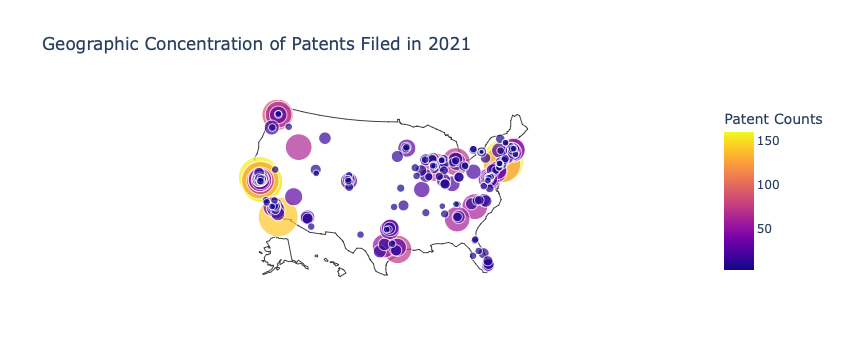

In [25]:
df_us = filtered_df

# Apply transformation for better scaling
df_us['Scaled Counts'] = df_us['Counts'] / df_us['Population']

# Create the scatter geo plot
fig = px.scatter_geo(
    df_us,
    lat='Latitude',
    lon='Longitude',
    #text='City',  # Optional: label points with city names
    hover_name= 'City',
    size='Counts',  # Use the transformed counts for size
    size_max= 30,  # Adjust max size of markers
    color='Counts',  # Color scale based on counts
    projection='albers usa',  # Choose projection type
    title="Geographic Concentration of Patents Filed in 2021"
)


fig.update_geos(
    landcolor="white",
    showcountries=True,
    showcoastlines=True,
    coastlinecolor="LightGray"
)

fig.update_layout(
    coloraxis_colorbar=dict(title="Patent Counts", tickformat=".2s")
)

fig.show()


# University Endowment Data

In [26]:
doe_key= 'D8TM7Li5hhre883IJ0Y6apw1qiWHmjLvbWo8bdmV'

In [27]:
# Define parameters for the API request
params = {
    "api_key": doe_key,
    "fields": "school.name,school.city,school.state,school.zip,location.lat,location.lon,school.endowment.begin,school.endowment.end",
    "per_page": 100,  # Adjust per page as necessary; max is 100
    "page": 0
}

endpoint = "https://api.data.gov/ed/collegescorecard/v1/schools"

# Initialize list to store data
endowment_data = []

# Make API requests in a loop to handle pagination
while True:
    response = requests.get(endpoint, params=params)
    
    # Check if the request was successful
    if response.status_code != 200:
        print(f"Error: Received status code {response.status_code}")
        print("Response content:", response.text)
        break

    data = response.json()
    
    # Check if 'results' key exists in the response data
    if "results" not in data:
        print("Error: 'results' key not found in response data")
        print("Response content:", data)
        break
    
    # Break loop if there are no more results
    if not data["results"]:
        break
    
    # Process each institution's data
    for institution in data["results"]:
        school_name = institution.get("school.name")
        city = institution.get("school.city")
        state = institution.get("school.state")
        zip_code = institution.get("school.zip")
        lat = institution.get("location.lat")
        lon = institution.get("location.lon")
        endowment_begin = institution.get("school.endowment.begin")
        endowment_end = institution.get("school.endowment.end")
        
        # Only include schools with both begin and end values for endowment
        if endowment_begin is not None and endowment_end is not None:
            # Calculate the change in endowment
            endowment_diff = endowment_end - endowment_begin
            
            # Append data to the list
            endowment_data.append({
                "school_name": school_name,
                "city": city,
                "state": state,
                "zip_code": zip_code,
                "latitude": lat,
                "longitude": lon,
                "endowment_begin": endowment_begin,
                "endowment_end": endowment_end,
                "endowment_diff": endowment_diff
            })
    
    # Increment the page count for pagination
    params["page"] += 1

# Convert the data to a DataFrame for easier handling and visualization
df_endowment = pd.DataFrame(endowment_data)

# Display the DataFrame to verify
#print(df_endowment.head())

# Save to CSV for further analysis or use with GIS tools
df_endowment.to_csv("endowment_changes.csv", index=False)
df_endowment

school_name         city state  \
0               University of Alabama at Birmingham   Birmingham    AL   
1                                Amridge University   Montgomery    AL   
2               University of Alabama in Huntsville   Huntsville    AL   
3                          Alabama State University   Montgomery    AL   
4                         The University of Alabama   Tuscaloosa    AL   
...                                             ...          ...   ...   
2695                       Madera Community College       Madera    CA   
2696  Evangel University-College of Online Learning  Springfield    MO   
2697                      Marian University-Ancilla     Plymouth    IN   
2698        Commonwealth University of Pennsylvania   Bloomsburg    PA   
2699                Pennsylvania Western University   California    PA   

        zip_code   latitude   longitude  endowment_begin  endowment_end  \
0     35294-0110  33.505697  -86.799345        711616804      673320170   
1     36117-3553  32.362609  -86.174010           174817         174819   
2          35899  34.724557  -86.640449        100321016       87756960   
3     36104-0271  32.364317  -86.295677        130589167      108202146   
4     35487-0100  33.211875  -87.545978       1237611651     1144632976   
...          ...        ...         ...              ...            ...   
2695  93638-8321  36.925132 -119.997870           209236         177287   
2696  65802-2125  37.220956  -93.262614           975016        1018528   
2697  46563-9475  41.337931  -86.445875          5912942        5126677   
2698       17815  41.007820  -76.447844         88339360       78738633   
2699       15419  40.064964  -79.886790        120204414      105049439   

      endowment_diff  
0          -38296634  
1                  2  
2          -12564056  
3          -22387021  
4          -92978675  
...              ...  
2695          -31949  
2696           43512  
2697         -786265  
2698        -9600727  
2699       -15154975  

[2700 rows x 9 columns]

In [28]:
# One sample of data, for plotting/visualization purposes
df_sampled = df_endowment.sample(n= 1000, random_state= 42)
df_sampled

school_name            city state  \
1339                          Adelphi University     Garden City    NY   
1222           The University of Montana-Western          Dillon    MT   
1106          Blue Mountain Christian University   Blue Mountain    MS   
812                                Bates College        Lewiston    ME   
1231                            Hastings College        Hastings    NE   
...                                          ...             ...   ...   
1087                Saint Cloud State University     Saint Cloud    MN   
105                 Art Center College of Design        Pasadena    CA   
1128               Pearl River Community College     Poplarville    MS   
1739                Union Institute & University      Cincinnati    OH   
121   California State University-San Bernardino  San Bernardino    CA   

        zip_code   latitude   longitude  endowment_begin  endowment_end  \
1339  11530-0701  40.721439  -73.653321        235144798      212345742   
1222  59725-3598  45.208306 -112.639264          7622623       10610167   
1106       38610  34.672090  -89.029240         20605815       18062246   
812        04240  44.105299  -70.203333        466016288      418543930   
1231       68901  40.590250  -98.374403        113074932      101507490   
...          ...        ...         ...              ...            ...   
1087  56301-4498  45.553227  -94.152657         44122000       40550000   
105        91103  34.169031 -118.185102        133281000      127039000   
1128       39470  30.844322  -89.543052             7901           7905   
1739       45206  39.119091  -84.497652          1022709         855298   
121   92407-2393  34.182622 -117.323801         55847119       46938805   

      endowment_diff  
1339       -22799056  
1222         2987544  
1106        -2543569  
812        -47472358  
1231       -11567442  
...              ...  
1087        -3572000  
105         -6242000  
1128               4  
1739         -167411  
121         -8908314  

[1000 rows x 9 columns]

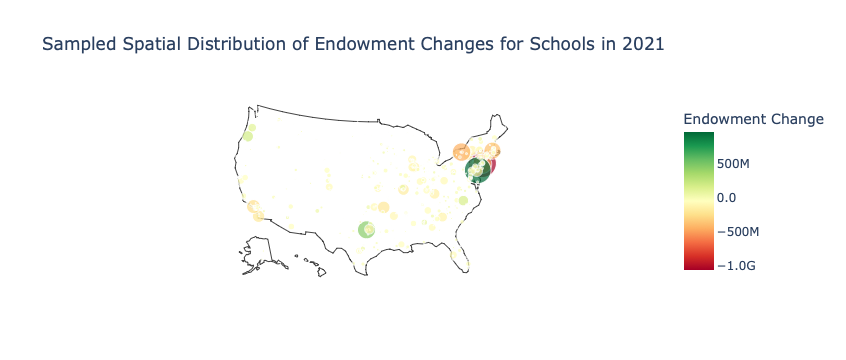

In [29]:
# Plot the data with Plotly

df_sampled["endowment_diff_size"] = df_sampled["endowment_diff"].abs()

fig = px.scatter_geo(
    df_sampled,
    lat="latitude",
    lon="longitude",
    hover_name="school_name",
    hover_data={"endowment_begin": True, "endowment_end": True, "endowment_diff": True, "city": True, "state": True},
    color="endowment_diff",
    color_continuous_scale="RdYlGn",
    size="endowment_diff_size",
    title="Sampled Spatial Distribution of Endowment Changes for Schools in 2021"
)

# Update map settings within update_geos (for geo-specific styling)
fig.update_geos(
    scope="usa",
    landcolor="white",
    showcountries=True,
    showcoastlines=True,
    coastlinecolor="LightGray"
)

# Update layout for color bar and additional layout settings
fig.update_layout(
    coloraxis_colorbar=dict(title="Endowment Change", tickformat=".2s")
)

fig.show()


In [30]:
df_sampled.columns

Index(['school_name', 'city', 'state', 'zip_code', 'latitude', 'longitude',
       'endowment_begin', 'endowment_end', 'endowment_diff',
       'endowment_diff_size'],
      dtype='object')

# Spatial Analysis

In [31]:
# Rename columns for merging
df_sampled.rename(columns={'city': 'City', 'state': 'State'}, inplace=True)

# Merge the DataFrames on 'City' and 'State'
merged_df = pd.merge(filtered_df, df_sampled, on=['City', 'State'], how='inner')
print(merged_df.columns)
merged_df = merged_df[['City', 'State', 'Counts', 'Population', 'Scaled Counts', 
                       'school_name', 'zip_code', 'latitude', 'longitude', 
                       'endowment_begin', 'endowment_end', 'endowment_diff']]

Index(['City', 'Latitude', 'Longitude', 'Population', 'State', 'Counts',
       'Scaled Counts', 'school_name', 'zip_code', 'latitude', 'longitude',
       'endowment_begin', 'endowment_end', 'endowment_diff',
       'endowment_diff_size'],
      dtype='object')


In [32]:
# correlation = merged_df['Counts'].corr(merged_df['endowment_diff'])
# print(f'Correlation coefficient between patent counts and endowment difference: {correlation}')
def calculate_correlation(data):
    return data['Counts'].corr(data['endowment_diff'], method= 'pearson')

In [33]:
n_iter= 1000
corr_values= []

for _ in range(n_iter):
    sample = merged_df.sample(frac= 1, replace= False)  # Sample without replacement
    corr = calculate_correlation(sample)
    corr_values.append(corr)

In [34]:
# Calculate confidence intervals
lower_bound = np.percentile(corr_values, 2.5)
upper_bound = np.percentile(corr_values, 97.5)

print(f'Bootstrap Correlation Coefficient: {np.mean(corr_values): .4f}')
print(f'95% Confidence Interval: [{lower_bound}, {upper_bound}]')

Bootstrap Correlation Coefficient: -0.1477
95% Confidence Interval: [-0.147741416615222, -0.1477414166152218]


In [35]:
# Scatter plot for the merged data
fig = px.scatter(
    merged_df,
    x='endowment_diff',
    y='Counts',
    hover_name='City',
    title='Patent Counts vs. Endowment Differences',
    labels={'endowment_diff': 'Endowment Difference', 'Counts': 'Patent Counts'}
)
fig.show()

In [36]:
# Geo scatter plot
fig_map = px.scatter_geo(
    merged_df,
    lat='latitude',
    lon='longitude',
    size='Counts',
    color='endowment_diff',
    hover_name='City',
    title='Patent Counts and Endowment Differences by Location',
    projection='albers usa'
)
fig_map.show()

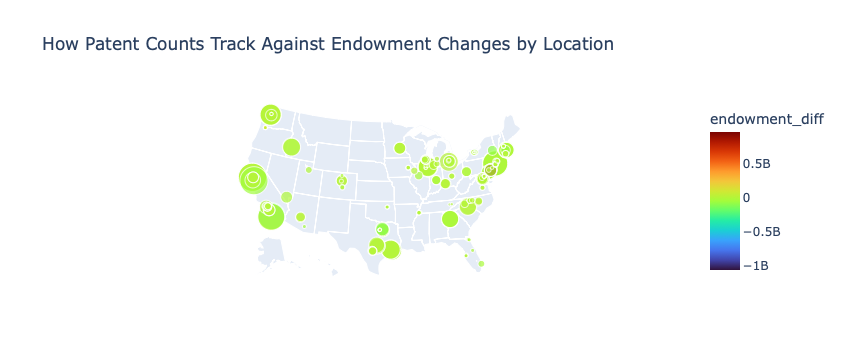

Correlation between Patent Counts and Endowment Change: -0.147741416615222


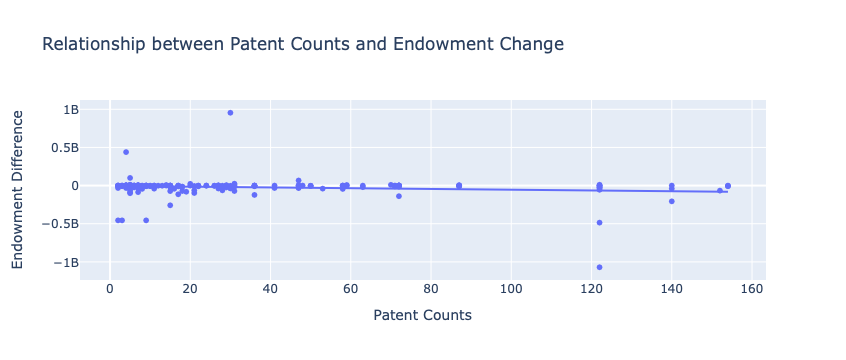

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     4.753
Date:                Sun, 01 Dec 2024   Prob (F-statistic):             0.0303
Time:                        22:44:22   Log-Likelihood:                -4309.2
No. Observations:                 215   AIC:                             8622.
Df Residuals:                     213   BIC:                             8629.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.412e+06   1.11e+07     -0.399      0.6

In [53]:
# USE THIS!!!!!!!!!

# Normalize `Counts` and `endowment_diff`
merged_df['Counts_scaled'] = (merged_df['Counts'] - merged_df['Counts'].min()) / (merged_df['Counts'].max() - merged_df['Counts'].min())
merged_df['endowment_diff_scaled'] = (merged_df['endowment_diff'] - merged_df['endowment_diff'].min()) / (merged_df['endowment_diff'].max() - merged_df['endowment_diff'].min())

fig_map = px.scatter_geo(
    merged_df,
    lat='latitude',
    lon='longitude',
    size='Counts_scaled',  # Size of markers shows patent counts
    color='endowment_diff',  # Color represents endowment differences
    hover_name='City',
    title='How Patent Counts Track Against Endowment Changes by Location',
    projection='albers usa',
    color_continuous_scale="Turbo"  # Optional: Use a diverging color scale for endowment changes
)

fig_map.show()

hover_data={
    'City': True,
    'Counts': True,
    'endowment_diff': True
}

correlation = merged_df[['Counts', 'endowment_diff']].corr().iloc[0, 1]
print(f"Correlation between Patent Counts and Endowment Change: {correlation}")

fig_scatter = px.scatter(
    merged_df,
    x='Counts',
    y='endowment_diff',
    title='Relationship between Patent Counts and Endowment Change',
    labels={'Counts': 'Patent Counts', 'endowment_diff': 'Endowment Difference'},
    trendline="ols"  # Adds a regression line
)
fig_scatter.show()


# Extract trendline results
trendline_results = px.get_trendline_results(fig_scatter)

# Get regression summary for the trendline
ols_results = trendline_results.px_fit_results.iloc[0]
print(ols_results.summary())



In [37]:
df= merged_df
# Perform MLR

# Add a constant column for the intercept term
df['constant'] = 1

# Separate the dependent and independent variables
X = df[['constant', 'endowment_diff']]  # Assuming 'X1' and 'X2' are the names of your predictor columns
y = df['Scaled Counts']  # Assuming 'y' is the name of your dependent variable column

# Fit the OLS model
model = sm.OLS(y, X)

# Run the fit
results = model.fit()

# Print results summary
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:          Scaled Counts   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                   0.03358
Date:                Sun, 01 Dec 2024   Prob (F-statistic):              0.855
Time:                        20:30:44   Log-Likelihood:                 1482.7
No. Observations:                 215   AIC:                            -2961.
Df Residuals:                     213   BIC:                            -2955.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
constant        9.673e-05    1.7e-05      5.

## Checking for Outliers

<Axes: >

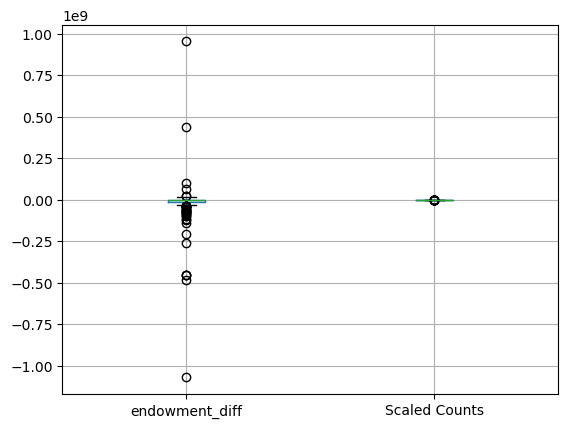

In [38]:
merged_df[['endowment_diff', 'Scaled Counts']].boxplot()

In [39]:
merged_df.columns

Index(['City', 'State', 'Counts', 'Population', 'Scaled Counts', 'school_name',
       'zip_code', 'latitude', 'longitude', 'endowment_begin', 'endowment_end',
       'endowment_diff', 'constant'],
      dtype='object')

In [40]:
import plotly.express as px

fig = px.scatter_mapbox(
    df_us,
    lat="Latitude",
    lon="Longitude",
    hover_name="City",
    size="Scaled Counts",
    size_max=30,
    color="Counts",
    zoom=3
)
fig.update_layout(mapbox_style="carto-positron")
fig.show()


In [41]:
!pip install cartopy geopandas

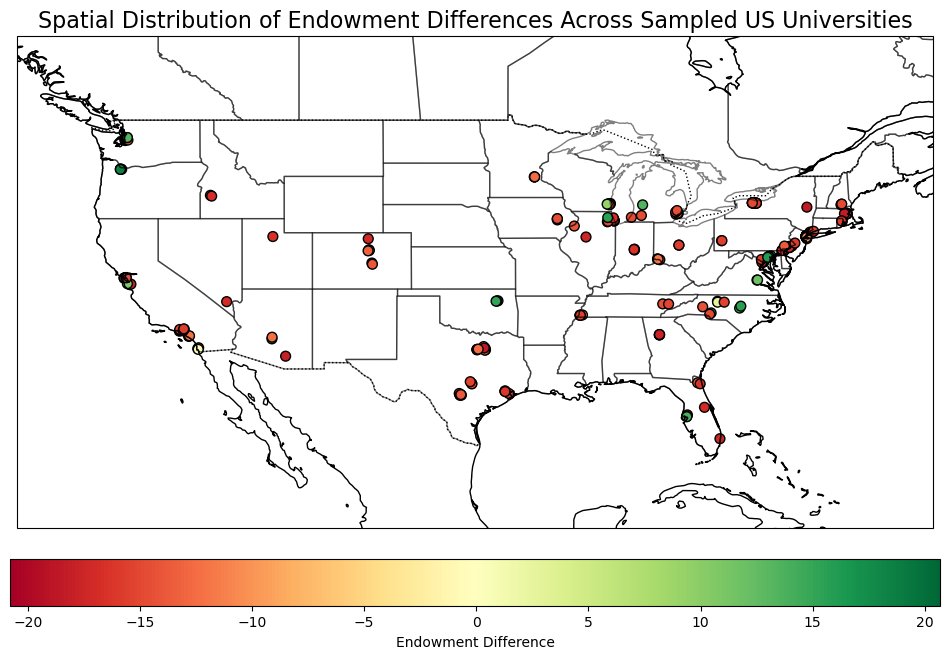

In [43]:
# Setting up the map
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-130, -65, 20, 55], crs=ccrs.PlateCarree())  # USA boundaries

# Adding map features
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle='-', alpha=0.5)

# Scaling so colorbar reflects variability better
df['log_endowment_diff'] = np.sign(df['endowment_diff']) * np.log1p(np.abs(df['endowment_diff']))

# Scatter plot of school locations
scatter = ax.scatter(
    df['longitude'], 
    df['latitude'], 
    c= df['log_endowment_diff'],
    #c=df['endowment_diff'],  # Color based on endowment difference
    cmap='RdYlGn', #'viridis', 
    s=50,  # Adjust size as needed
    edgecolor='k', 
    transform=ccrs.PlateCarree()
)

# Adding colorbar
cbar = plt.colorbar(scatter, ax=ax, orientation='horizontal', pad=0.05, label='Endowment Difference')

# Add title
plt.title("Spatial Distribution of Endowment Differences Across Sampled US Universities", fontsize=16)
plt.show()


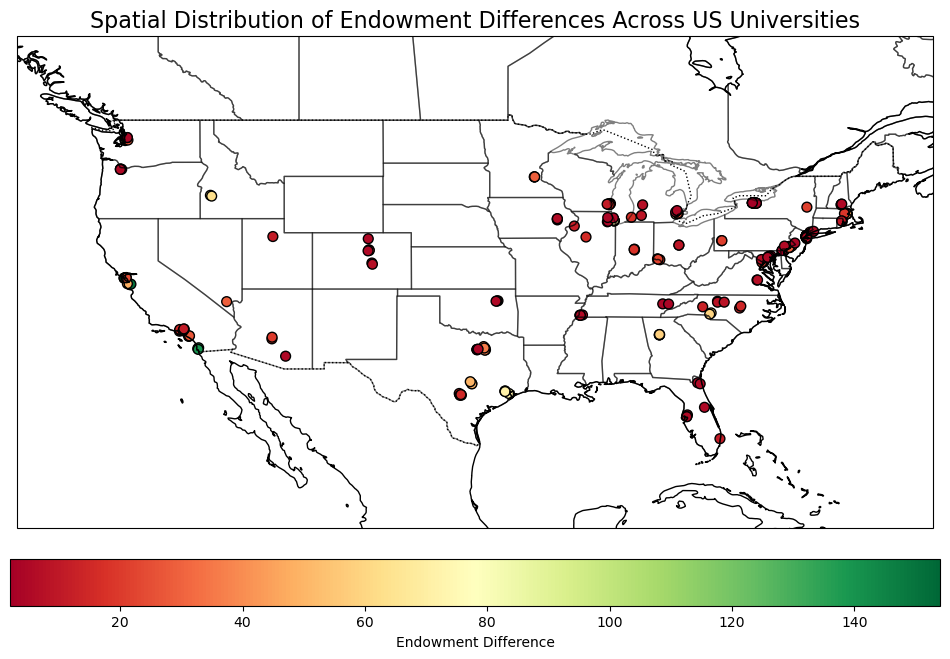

In [44]:
# Set up the map
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-130, -65, 20, 55], crs=ccrs.PlateCarree())  # USA boundaries

# Add map features
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle='-', alpha=0.5)

# Scatter plot of school locations
scatter = ax.scatter(
    df['longitude'], 
    df['latitude'], 
    c=df['Counts'],  # Color based on endowment difference
    cmap='RdYlGn', #'viridis', 
    s=50,  # Adjust size as needed
    edgecolor='k', 
    transform=ccrs.PlateCarree()
)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, orientation='horizontal', pad=0.05, label='Endowment Difference')

# Add title
plt.title("Spatial Distribution of Endowment Differences Across US Universities", fontsize=16)
plt.show()


In [45]:
merged_df

City State  Counts  Population  Scaled Counts  \
0    San Francisco    CA     154      873965       0.000176   
1    San Francisco    CA     154      873965       0.000176   
2    San Francisco    CA     154      873965       0.000176   
3      Santa Clara    CA     152      130000       0.001169   
4        San Diego    CA     140     1386932       0.000101   
..             ...   ...     ...         ...            ...   
210     Fort Worth    TX       4      956709       0.000004   
211     Fort Worth    TX       4      956709       0.000004   
212       Palatine    IL       4       67482       0.000059   
213        Bothell    WA       4       48161       0.000083   
214        Bothell    WA       4       48161       0.000083   

                                       school_name    zip_code   latitude  \
0         California Institute of Integral Studies       94103  37.774924   
1              San Francisco Conservatory of Music  94102-6011  37.775543   
2                           Golden Gate University  94105-2968  37.789374   
3                           Santa Clara University       95053  37.348362   
4                          University of San Diego  92110-2492  32.770816   
..                                             ...         ...        ...   
210  The Southwestern Baptist Theological Seminary       76115  32.681685   
211                      Texas Wesleyan University  76105-1536  32.732962   
212                  William Rainey Harper College  60067-7398  42.081829   
213        University of Washington-Bothell Campus  98011-8246  47.759773   
214                               Cascadia College  98011-8205  47.760915   

      longitude  endowment_begin  endowment_end  endowment_diff  constant  \
0   -122.416102          1968374        1532318         -436056         1   
1   -122.420292         55862000       49497000        -6365000         1   
2   -122.398969         50637080       43299581        -7337499         1   
3   -121.937840       1537642000     1471579000       -66063000         1   
4   -117.192073        692916000      652516000       -40400000         1   
..          ...              ...            ...             ...       ...   
210  -97.348233        149795926      142295273        -7500653         1   
211  -97.279613         73607396       73285787         -321609         1   
212  -88.072811         32792450       38427998         5635548         1   
213 -122.191293         93699617       93819217          119600         1   
214 -122.191572          2037443        2629186          591743         1   

     log_endowment_diff  
0            -12.985528  
1            -15.666325  
2            -15.808509  
3            -18.006119  
4            -17.514340  
..                  ...  
210          -15.830501  
211          -12.681095  
212           15.544605  
213           11.691916  
214           13.290829  

[215 rows x 14 columns]